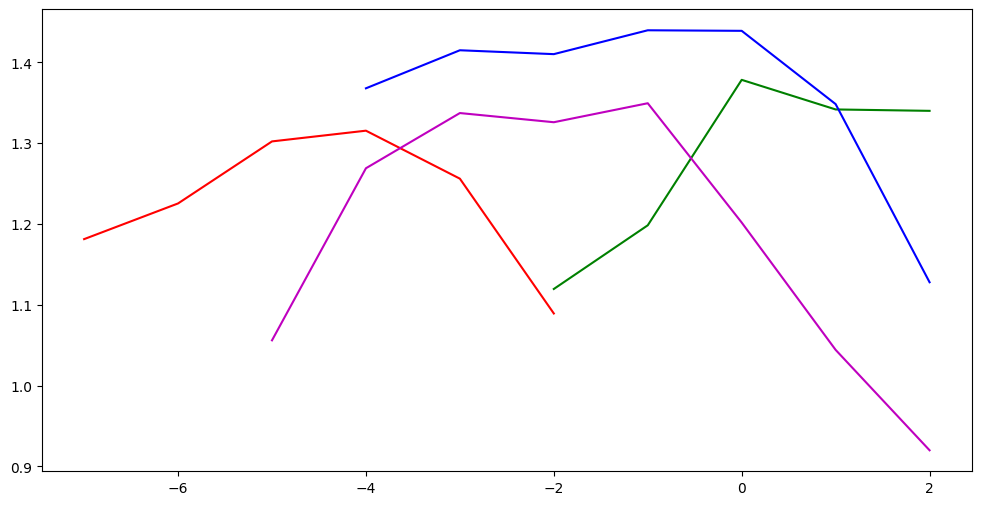

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import math
import profile
from chapter2 import  *

class Bandit:
    
    def init_task(self):
        pass

    def select_arm(self, step):
        pass
    
    def update_step(self, step, idx, reward):
        pass

    def run(self, reward_bias, reward_variance):
        num_tasks, self.num_arms = reward_bias.shape
        num_steps = len(reward_variance)
        avg_avg_rewards = np.zeros(num_steps)
        avg_optimal_actions = np.zeros(num_steps)
        for t in range(num_tasks):
            reward_variance = np.random.randn(num_steps)
            self.init_task()
            rewards = reward_bias[t]
            self.avg_rewards = np.zeros(num_steps)
            optimal_actions = np.zeros(num_steps)
            cum_reward = 0.0
            cum_optimal_action = 0
            optimal_action_index = rewards.argmax()
            offsets = np.random.randn(num_steps)
            for s in range(num_steps):
                idx = self.select_arm(s)
                reward = rewards[idx] + reward_variance[s]
                self.update_step(s, idx, reward)
                cum_reward += reward
                self.avg_rewards[s] = cum_reward/(s+1)
                if idx == optimal_action_index:
                    cum_optimal_action += 1 
                optimal_actions[s] = float(cum_optimal_action)/float(s+1)
            avg_avg_rewards += (self.avg_rewards - avg_avg_rewards)/(t+1)
            avg_optimal_actions += (optimal_actions  - avg_optimal_actions)/(t+1)
        return avg_avg_rewards, avg_optimal_actions 
    

class ValueBasedBandit(Bandit):
    def init_task(self):
        self.qs = np.zeros(self.num_arms, dtype = np.float32)
        self.ns = np.zeros(self.num_arms, dtype = np.int32)
    
    def update_step(self, step, idx, reward):
        self.qs[idx] += (reward - self.qs[idx]) / (self.ns[idx] + 1)
        self.ns[idx] += 1


class EpsilonGreedyBandit(ValueBasedBandit):
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def select_arm(self, step)->int:
        return epsilon_greedy(self.qs, self.epsilon)


class  OIVBandit(ValueBasedBandit):
    def __init__(self, init_q):
        self.init_q = init_q

    def select_arm(self, step)->int:
        return greedy(self.qs)
    
    def init_task(self):
        super().init_task()
        self.qs = np.full(self.num_arms, self.init_q, dtype = np.float32)


class UCBBandit(ValueBasedBandit):
    def __init__(self, coefficient):
        self.coefficient = coefficient

    def select_arm(self, step)->int:
        if step < self.num_arms:
            return step
        else:
            return ucb(self.qs, self.ns, step, self.coefficient)


class GridentBandit(Bandit):
    def __init__(self, alpha):
        self.alpha = alpha

    def init_task(self):
        self.hs = np.zeros(self.num_arms)

    def select_arm(self, step)->int:
        self.ps = softmax(self.hs)
        return np.random.choice(int(self.num_arms), p = self.ps)
    
    def update_step(self, step, idx, reward):
        mask = np.zeros(self.num_arms)
        mask[idx] = 1
        self.hs += self.alpha*(reward - self.avg_rewards[step])*(mask - self.ps)


def test():

    num_arms = 10
    num_steps = 1000
    num_tasks = 100
    reward_bias = np.random.randn(num_tasks, num_arms)
    reward_variance = np.random.randn(num_steps)


    params = [
        [EpsilonGreedyBandit, -7, -1, [], "r"],
        [OIVBandit, -2, 3, [], "g"],
        [UCBBandit, -4, 3, [], "b"],
        [GridentBandit, -5, 3, [], "m"],        
    ]

    for param in params:
        for n in range(param[1], param[2]):
            a = math.pow(2, n)
            bandit = param[0](a)
            rewards, actions = bandit.run(reward_bias, reward_variance)
            param[3].append(rewards[-1])

    plt.figure(figsize=(12, 6))
    for param in params:
        plt.plot(range(param[1], param[2]), param[3], param[4])



test()

0.5